# Demonstration of shifty.py's "preparer" module
 - 201911XX & 202002XX
 - Payne 
 
The "preparer" module facilitates loading fits files from disk into a "STACKED FITS FILE" 
 - To do this requires not only simple loading, but also more detailed "cleaning" and "preparation" of the data to ensure that the stacked fits file object that is ultimately created has only the required, clean data in it. 

There is a "parent" class" called "ImagePreparer".
 - This is NOT likely to be used directly at all 

There are "child" classes for each type of data that will be downloaded:
 - These ARE likely to be directly used in practice. 
 
It intended that there be a specific loader for a specific kind of data.
E.g.
 - The "TESSImagePreparer" class provides methods to download TESS data (from mast)
 - The "HSTImagePreparer" class is just a stub and does not yet have much functionality
 
This notebook:
 - Demonstrates the key components / classes / functions available in the loader module
 - Acts as a complement to the tests of the same module. 

#### Import statements 

In [20]:
# -------------------------------------------------------------------------------------
# Third party imports
# -------------------------------------------------------------------------------------
import numpy as np 
import matplotlib.pyplot as plt
import os, sys
import glob 

import astropy
from astropy.io import fits
from astropy.time import Time
from astropy.units import allclose as quantity_allclose
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates.builtin_frames import FK5, ICRS, GCRS, GeocentricMeanEcliptic, BarycentricMeanEcliptic, HeliocentricMeanEcliptic, GeocentricTrueEcliptic, BarycentricTrueEcliptic, HeliocentricTrueEcliptic, HeliocentricEclipticIAU76
from astropy.constants import R_sun, R_earth

import importlib

# -------------------------------------------------------------------------------------
# Local imports
# -------------------------------------------------------------------------------------
sys.path.append(os.path.join(os.path.split(os.getcwd())[0], 'shifty'))
import data 
import downloader 
import preparer
import refcat

importlib.reload(data)
importlib.reload(preparer)
importlib.reload(downloader)
importlib.reload(refcat)



<module 'refcat' from '/Users/matthewjohnpayne/Envs/shifty/shifty/refcat.py'>

# Examples of some *HIGH LEVEL, PUBLIC* functionaliteis from TESSImagePreparer
 - These are the functionalities that we expect to be used externally
 - Lower-level funcs are demo'ed below

### Instantiate TESSImagePreparer object
 - Note that TESSImagePreparer object has an 'obs_code' quantity: this is passed into the output ImageDataSet to allow later understanding/calculation of the location of the observatory as a function of time. 

In [2]:
# creation of TESSImageLoader object
T = preparer.TESSImagePreparer()

# examination of instantiated variables
# - these are defining some local data storage 
for k,v in T.__dict__.items():
    print(k,v)
print()

# check that storage directories exist on disk 
for d in [T.local_dir, T.tess_dir ]:
    print( 'It is *%r* that %r exists on disk' % (os.path.isdir(d), d)  )

local_dir /Users/matthewjohnpayne/.shifty_data
obs_code C57
tess_dir /Users/matthewjohnpayne/.shifty_data/tess

It is *True* that '/Users/matthewjohnpayne/.shifty_data' exists on disk
It is *True* that '/Users/matthewjohnpayne/.shifty_data/tess' exists on disk


### Use TESSImagePreparer to generate a  "stack_file" based on just a small set of development data
 - Note that this loads 10 fits files into a combined/stacked fits file (development = True , automatically specifies a fixed set of 10 files to be used)
 - Note that this does *no* cleaning (the default is to do no cleaning)  

In [3]:
# Delete demo stack file if it already exists 
stack_filepath = '/Users/matthewjohnpayne/.shifty_data/shift.fits'
if os.path.isfile(stack_filepath): os.remove(stack_filepath)

# load the test data(this is specified below by passing in development = True)
stack_fits_filepath = T.generate_cleaned_stack_file( development = True )

# check that the returned object actually is an ImageDataSet 
print('It is %r that the returned object is a valid filepath: (%s)' % ( os.path.isfile(stack_fits_filepath) , 
                                                                      stack_fits_filepath ) )



It is True that the returned object is a valid filepath: (/Users/matthewjohnpayne/.shifty_data/shift.fits)


### Use TESSImagePreparer to load prf's (previously downloaded using the TESSDownloader module)
 - *** NOT YET OPERATIONAL ***

### Use TESSImageLoader to perform various "cleaning" tasks ... 

#### masking stars
 - It may be of use to simply 'mask-out' the regions/pixels on an image that have stars on them. 
 - Here we pass a mask=True option to the *get_image_data_set()* function to turn-on the masking
 - Note that this is ultimately calling the _mask_stars() function to do the work of masking

In [ ]:
IDU = T.generate_cleaned_stack_file( **{'development' : True , 'mask' : True } )
print(' * AT PRESENT THIS DOES NOTHING BECAUSE THE MASK FUNCTION JUST PASSES THE DATA THROUGH WITHOUT DOING ANYTHING !!!! * ')

# Examples of some *LOW LEVEL, PRIVATE* functionality from TESSImagePreparer
 - Just demonstrating how they work, etc : hopefully they won't need to be used (much?) in practice

##### _ parse _ filespec
 - Convenience function to allow passed-in-parameters to flexibly specify the files that are to be loaded from FITS file 

In [ ]:
# (i)(a) should get simple pass-through of file-list when 'fits_filepaths' used
result = T._parse_filespec( fits_filepaths = T._ensure_test_data_available_locally() )
assert result == T._ensure_test_data_available_locally(), \
    'did not get simple pass-through of fits_filepaths'

# (i)(b) should get filepaths for development files when 'development' = True is specified
result = T._parse_filespec( development = True )
assert result == T._ensure_test_data_available_locally(), \
    'did not get development fits_filepaths'

# (i)(c) should get all filepaths in chip sub-dir when 'sectorNumber', 'cameraNumber', 'chipNumber' specified
sectorNumber, cameraNumber, chipNumber = 4,3,2
result = T._parse_filespec(sectorNumber = sectorNumber,
                           cameraNumber = cameraNumber,
                           chipNumber   = chipNumber )
result.sort()
expected_directory_path = os.path.join( T.tess_dir,str(sectorNumber),str(cameraNumber),str(chipNumber))
expected_fits_filepaths = glob.glob( os.path.join(expected_directory_path , '*.fits') )
expected_fits_filepaths.sort()
assert result == expected_fits_filepaths, \
    'did not get expected_fits_filepaths for %r' % expected_directory_path


##### _ parse _ filespec
 - Convenience function to allow passed-in-parameters to flexibly specify the "patch" of a fits-array that will be used (i.e. we cut-out a slice of the array)
 - The specification is in terms of pixel indicees 

In [ ]:
# (ii) test the private-method *_parse_patchspec()*
# (ii)(a) if use pythonic-zero-based-numbering, then numbers unaltered
X0,X1,Y0,Y1 = 11,17,1,4
x0,x1,y0,y1 = T._parse_patchspec(patch=True, python=True, xlim=(X0,X1), ylim=np.array([Y0,Y1]) )
assert [x0,x1,y0,y1]==[X0,X1,Y0,Y1], \
    'returned limits are not as expected ... %r' % [x0,x1,y0,y1]

# (ii)(b) if use pixel-one-based-numbering, then numbers shifted by one
X0,X1,Y0,Y1 = 11,17,1,4
x0,x1,y0,y1 = T._parse_patchspec(patch=True, pixel=True, xlim=(X0,X1), ylim=np.array([Y0,Y1]) )
assert [x0,x1,y0,y1]==[X0-1,X1-1,Y0-1,Y1-1], \
    'returned limits are not as expected ... %r' % [x0,x1,y0,y1]


##### _ initialize _ stack _ HDUlist
 - should create a fits-file and an hdulist

In [ ]:
# test the private-method *_initialize_stack_HDUlist()*
# - should create a fits-file and an hdulist
stack_filepath = os.path.join(T._fetch_data_directory(), 'stack.fits')
if os.path.isfile(stack_filepath):
    os.remove(stack_filepath)
assert not os.path.isfile(stack_filepath)
result = T._initialize_stack_HDUlist(stack_filepath)
assert isinstance( result, astropy.io.fits.hdu.hdulist.HDUList)
assert os.path.isfile(stack_filepath)


##### _ clean _ data
 - Wrapper around the various "cleaning" methods that have-been/will-be implemented 


##### _ mask _ stars

In [21]:
importlib.reload(preparer)
T = preparer.TESSImagePreparer()

# Need to create header, image_data 
list_of_HDUs = T._load_test_images()
header  = list_of_HDUs[0][1].header
data    = list_of_HDUs[0][1].data

# create a copy of the original *before* any masking 
import copy 
orig    = copy.deepcopy(data) 

In [22]:
importlib.reload(refcat)
# run the script *find_all_stars_on_image()*
# - This is *NOT* necessary for running / demonstrating the "preparer" functions
# - I just want it for the purposes of visualization
# -----------------------------------------
ra, dec, pix, int_pix = refcat.RefCat().find_all_stars_on_image(header , orig )

              **              WARNING: HARD-CODED MAG-LIMITS & SEARCH DIRECTORIES IN find_all_stars_on_image()              **              


In [23]:
# run the mask_stars script that I am attempting to demonstrate ...
kwargs = { 'dummy_key' : True , 'refcat_dict' : {} }
T._mask_stars(header , data, **kwargs)

in calc loop
              **              WARNING: HARD-CODED MAG-LIMITS & SEARCH DIRECTORIES IN find_all_stars_on_image()              **              
 ** WARNING: just outputting a single central mask pixel at present ** 


Pixel value of sources ... translated by -1, -1 inside *find_all_stars_on_image()* to match with positions in data-array from fits


(50, 85)

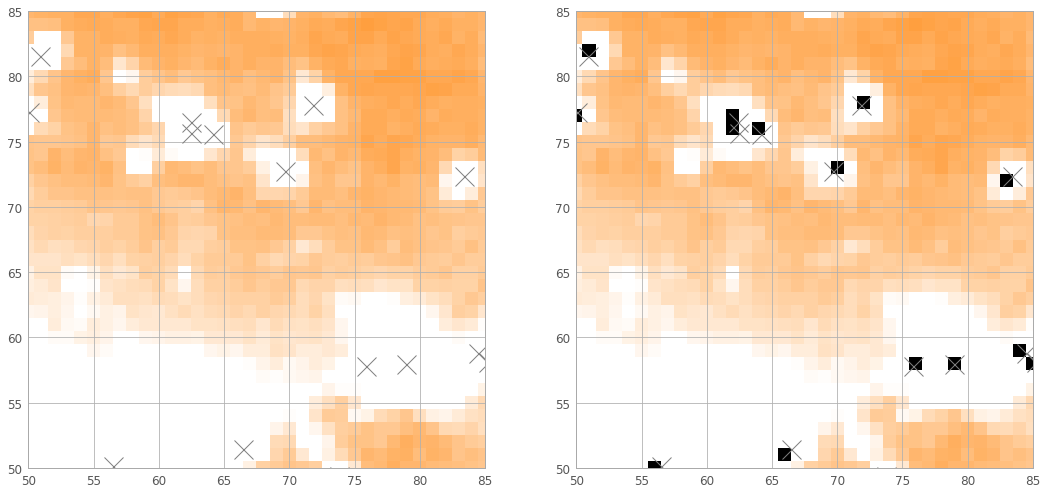

In [29]:
# set up plot environment 
# -----------------------------------------
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(18,9))

# plot the FFIs before & after masking
# -----------------------------------------
cb = ax0.imshow(orig,  vmin=85.00, vmax=150.)
cb = ax1.imshow(data,  vmin=85.00, vmax=150.)

# plot the sources from refcat
# -----------------------------------------
ax0.plot(pix[0], pix[1], 'x', color='gray', alpha=2. , ms=19.)
ax1.plot(pix[0], pix[1], 'x', color='gray', alpha=2. , ms=19.)
xmin, xmax, ymin, ymax = 50,85 , 50,85
print('Pixel value of sources ... translated by -1, -1 inside *find_all_stars_on_image()* to match with positions in data-array from fits')
for xp, yp in zip(pix[0], pix[1]):
    if xp > xmin and xp < xmax and yp > ymin and yp < ymax:
        pass #print(xp-1, yp-1)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymin, ymax])
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymin, ymax])
